# Part 5: Time Series with Long Short Term Memory(LSTM) 
# &emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Recurrent Neural Network

<br>

In this part we will try to build and train Long Short Term Memory Recurrent Neural Network for our time series data. Let's first take a brief overview of LSTM.<br>

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (such as images), but also entire sequences of data (such as speech or video).<br>

Instead of neurons, LSTM networks have memory blocks that are connected through layers.
### Why LSTM for Time Series?
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.
<br><br>
We will use Keras with Tensorflow at backend for building our Neural Network.

In [21]:
# import necessary files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os


### &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;Selecting Input and Output Shapes in LSTM

<img src="lstm.png" class="img-responsive" alt=""> </div>

<br>


The input data to LSTM looks like the above[[1]](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e) diagram.<br><br>
<b>Note:</b> We always have to give a three-dimensional array as an input to your LSTM network. Where the first dimension represents the <b>batch size</b>, the second dimension represents the <b>time-steps</b> and the third dimension represents the <b>number of units</b> in one input sequence.
For example, the input shape looks like <b>(batch_size, time_steps, seq_len).

#### Designing the Architecture of  LSTM neural network

In [2]:
# Let's design the Architecture of our LSTM neural network
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 6, activation = 'relu', epochs = 10):
    ''''
        train_data: train data for training the model
        test_data: test data for evaluating the model
        activation: activation function. Default is 'relu'.
        return: lstm model

        Note:
        1) time_steps: 12 for monthly, 365 for daily data is preffered.
        2) batch size: let's keep batch size to any fixed size. We will fix it at 6.
    
    '''
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    # Since we want to build LSTM network, In Keras we can simply stack multiple layers on top of each other,
    # for this we need to initialize the model as Sequential().
    model = Sequential()

    # add input layer. 
    #           units: We can take units as any no of dimensions(positive) for the outer space.
    #           activation: softmax, relu, softsign etc.
    model.add(LSTM(units = 200, activation = activation, input_shape = (time_steps, n_features)))

    # Dropout: Every LSTM layer should be accompanied by a Dropout layer.
    #          20% is often used as a good compromise between retaining model accuracy
    #          and preventing overfitting.
    model.add(Dropout(0.25))

    # add output layer the model. Since our model is making 
    # single predictions we'll take output layer as 1.
    model.add(Dense(1))
    # compile the model. Generally we use 'adam' optimiser. Let's take loss as mean square error. 
    model.compile(optimizer='adam', loss='mse')
    # fit the lstm neural network
    model.fit_generator(generator, epochs = epochs)
    
    return model

In [3]:
# function for predicting data for LSTM
def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):
    '''
        scaled_train_data: scaled train data.
        scaler: MinMaxScaler object for inverting transformations.
        scaled_test_data:  scaled test data.
        train_data:  train data.
        test_data:   test data.
        time_steps: Time steps
        n_features: Number of units in one input sequence.
        lstm_model: The LSTM model to evaluate.
        return : Predicted values.
    '''
    # for storing predicted values.
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    # print pollutant name
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    
    return df_predict

In [58]:
# function for evaluating the model
def evaluate_LSTM(actual, predicted):
    '''
        actual: actual values
        predicted: predicted values
        return: None
        
        calculates Mean square Error, Mean Absolute error and Root Mean Square Error
        
    '''
    # print pollutant name
    print('\nEvaluation of ',actual.columns.values[0])
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 4)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 4)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse,4)))
    
    # save results locally
    if not os.path.exists('result'): os.mkdir('result')
    if not os.path.exists('result/lstm.csv'):
        # create result dataframe for storing evaluation results(initialized with zeros)
        pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0.0,0.0,0.0], 'PM10': [0.0,0.0,0.0],
                                  'SO2': [0.0,0.0,0.0], 'NO2': [0.0,0.0,0.0],
                                  'CO': [0.0,0.0,0.0], 'O3': [0.0,0.0,0.0],


                            }).to_csv('result/lstm.csv',index = False)
        
    # read the lstm.csv file
    result = pd.read_csv('result/lstm.csv', dtype = {'EM':str})
    # set index as EM (Evaluation Matrix)
    result.set_index('EM', inplace = True)
    # write all the results
    result[actual.columns.values[0]]['mse'] = round(mse, 4)
    result[actual.columns.values[0]]['mae'] = round(mae, 4)
    result[actual.columns.values[0]]['rmse'] = round(rmse, 4)
    # save the file after writing
    result.to_csv('result/lstm.csv')
    # display successfull write message
    print('\nResults for {} successfully saved to result/lstm.csv'.format(actual.columns.values[0]))

In [5]:
# Scaling Train-Test data
def transform_data(train_data):
    '''
        train_data: Train data
        test_data: Test data
        return: (scaled_train_data, scaler)
    '''
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

#### Applying LSTM to daily data of PM2.5
Let's first apply our LSTM model to daily data of PM2.5.

In [6]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In order to feed our data into the neural network We need to first format our data into the specific format. Usually we scale data between either between (0,1) or (-1,1). We will use MinMaxScaler of scikitlearn library which will automatically scale the data.

In [7]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [8]:
# define parameters for the LSTM model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 365
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the LSTM model
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
122/122 [==============================] - 38s 310ms/step - loss: 0.0213
Epoch 2/10
122/122 [==============================] - 36s 296ms/step - loss: 0.0190
Epoch 3/10
122/122 [==============================] - 36s 297ms/step - loss: 0.0189
Epoch 4/10
122/122 [==============================] - 37s 300ms/step - loss: 0.0181
Epoch 5/10
122/122 [==============================] - 36s 298ms/step - loss: 0.0176
Epoch 6/10
122/122 [==============================] - 37s 303ms/step - loss: 0.0169
Epoch 7/10
122/122 [==============================] - 37s 300ms/step - loss: 0.0166
Epoch 8/10
122/122 [==============================] - 37s 304ms/step - loss: 0.0160
Epoch 9/10
122/122 [==============================] - 37s 299ms/step - loss: 0.0160
Epoch 10/


Predictions of  PM2.5


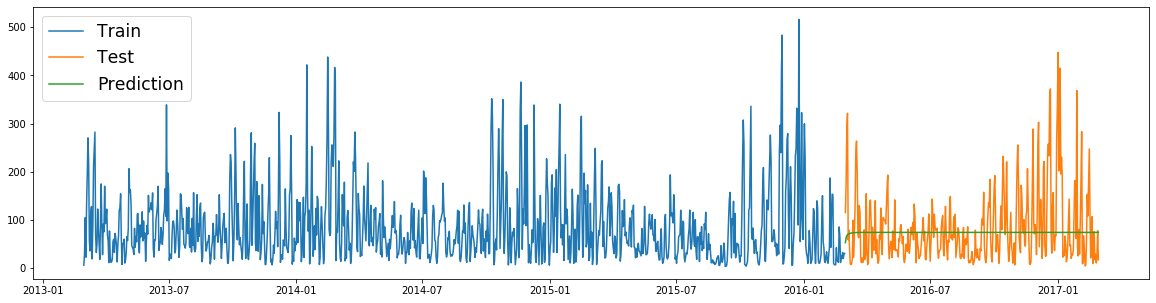

In [9]:
# Predict PM2.5 using LSTM
predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)

In [10]:
# Plot the predictions for PM2.5 pollutant
evaluate_LSTM(test_PM25, predictions)


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 5762.76
The Mean Absolute Error of the forecasts is 52.36
The Root Mean Squared Error of the forecasts is 75.91282305565827


It's look like our model is having a hard time fitting the daily data. Hyperparameter Tuning is required. Since the daily data is quite large, Hyperparameter Tuning will take a lot of time. So due to Time constraints let's move on monthly data.

#### Applying LSTM model on all the monthly pollutants data

In [11]:
# load all monthly datasets
train_PM25 = pd.read_csv('dataset/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('dataset/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [12]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [13]:
# define parameters for the LSTM model (After some manual hyperparameter tuning)
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 12
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# set epochs to 350
epochs = 350
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit LSTM model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting LSTM on ',list_train[i].columns.values[0])
    list_models.append(fit_LSTM(list_scaled_train[i], time_steps, n_feature, epochs = epochs))


Fitting LSTM on  PM2.5
Epoch 1/350
4/4 [==============================] - 1s 294ms/step - loss: 0.1512
Epoch 2/350
4/4 [==============================] - 0s 26ms/step - loss: 0.1053
Epoch 3/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0597
Epoch 4/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0653
Epoch 5/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0759
Epoch 6/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0668
Epoch 7/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0682
Epoch 8/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0628
Epoch 9/350
4/4 [==============================] - 0s 55ms/step - loss: 0.0668
Epoch 10/350
4/4 [==============================] - 0s 20ms/step - loss: 0.0633
Epoch 11/350
4/4 [==============================] - 0s 55ms/step - loss: 0.0599
Epoch 12/350
4/4 [==============================] - 0s 20ms/step - loss: 0.0624
Epoch 13/350
4/4 [======

4/4 [==============================] - 0s 28ms/step - loss: 0.0400
Epoch 104/350
4/4 [==============================] - 0s 55ms/step - loss: 0.0400
Epoch 105/350
4/4 [==============================] - 0s 21ms/step - loss: 0.0444
Epoch 106/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0332
Epoch 107/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0332
Epoch 108/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0459
Epoch 109/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0368
Epoch 110/350
4/4 [==============================] - 0s 55ms/step - loss: 0.0371
Epoch 111/350
4/4 [==============================] - 0s 62ms/step - loss: 0.0482
Epoch 112/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0373
Epoch 113/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0575
Epoch 114/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0651
Epoch 115/350
4/4 [=======================

4/4 [==============================] - 0s 37ms/step - loss: 0.0284
Epoch 205/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0276
Epoch 206/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0296
Epoch 207/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0205
Epoch 208/350
4/4 [==============================] - 0s 47ms/step - loss: 0.0340
Epoch 209/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0346
Epoch 210/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0385
Epoch 211/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0210
Epoch 212/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0242
Epoch 213/350
4/4 [==============================] - 0s 61ms/step - loss: 0.0277
Epoch 214/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0355
Epoch 215/350
4/4 [==============================] - 0s 47ms/step - loss: 0.0257
Epoch 216/350
4/4 [=======================

4/4 [==============================] - 0s 31ms/step - loss: 0.0231
Epoch 306/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0131
Epoch 307/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0237
Epoch 308/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0169
Epoch 309/350
4/4 [==============================] - 0s 30ms/step - loss: 0.0145
Epoch 310/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0147
Epoch 311/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0202
Epoch 312/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0175
Epoch 313/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0148
Epoch 314/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0188
Epoch 315/350
4/4 [==============================] - 0s 48ms/step - loss: 0.0146
Epoch 316/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0122
Epoch 317/350
4/4 [=======================

4/4 [==============================] - 0s 40ms/step - loss: 0.0804
Epoch 57/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0723
Epoch 58/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0725
Epoch 59/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0692
Epoch 60/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0664
Epoch 61/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0722
Epoch 62/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0649
Epoch 63/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0749
Epoch 64/350
4/4 [==============================] - 0s 46ms/step - loss: 0.0671
Epoch 65/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0680
Epoch 66/350
4/4 [==============================] - 0s 40ms/step - loss: 0.0663
Epoch 67/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0745
Epoch 68/350
4/4 [==============================] - 0

4/4 [==============================] - 0s 42ms/step - loss: 0.0677
Epoch 158/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0634
Epoch 159/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0663
Epoch 160/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0592
Epoch 161/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0649
Epoch 162/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0525
Epoch 163/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0641
Epoch 164/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0577
Epoch 165/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0618
Epoch 166/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0784
Epoch 167/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0685
Epoch 168/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0552
Epoch 169/350
4/4 [=======================

4/4 [==============================] - 0s 64ms/step - loss: 0.0448
Epoch 259/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0398
Epoch 260/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0474
Epoch 261/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0480
Epoch 262/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0359
Epoch 263/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0606
Epoch 264/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0592
Epoch 265/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0389
Epoch 266/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0517
Epoch 267/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0493
Epoch 268/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0623
Epoch 269/350
4/4 [==============================] - 0s 30ms/step - loss: 0.0480
Epoch 270/350
4/4 [=======================

Epoch 9/350
4/4 [==============================] - 0s 54ms/step - loss: 0.0279
Epoch 10/350
4/4 [==============================] - 0s 21ms/step - loss: 0.0289
Epoch 11/350
4/4 [==============================] - 0s 53ms/step - loss: 0.0275
Epoch 12/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0271
Epoch 13/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0269
Epoch 14/350
4/4 [==============================] - 0s 28ms/step - loss: 0.0257
Epoch 15/350
4/4 [==============================] - 0s 53ms/step - loss: 0.0249
Epoch 16/350
4/4 [==============================] - 0s 22ms/step - loss: 0.0246
Epoch 17/350
4/4 [==============================] - 0s 52ms/step - loss: 0.0231
Epoch 18/350
4/4 [==============================] - 0s 23ms/step - loss: 0.0207
Epoch 19/350
4/4 [==============================] - 0s 56ms/step - loss: 0.0147
Epoch 20/350
4/4 [==============================] - 0s 19ms/step - loss: 0.0171
Epoch 21/350
4/4 [=======================

Epoch 111/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0028
Epoch 112/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0039
Epoch 113/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0017
Epoch 114/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0013
Epoch 115/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0015
Epoch 116/350
4/4 [==============================] - 0s 28ms/step - loss: 0.0018
Epoch 117/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0047
Epoch 118/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0043
Epoch 119/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0011
Epoch 120/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0020
Epoch 121/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0010
Epoch 122/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0014
Epoch 123/350
4/4 [=========

4/4 [==============================] - 0s 37ms/step - loss: 0.0013
Epoch 212/350
4/4 [==============================] - 0s 42ms/step - loss: 9.2550e-04
Epoch 213/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0018
Epoch 214/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0013
Epoch 215/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0020
Epoch 216/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0010
Epoch 217/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0013
Epoch 218/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0011
Epoch 219/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0017
Epoch 220/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0015
Epoch 221/350
4/4 [==============================] - 0s 27ms/step - loss: 8.1744e-04
Epoch 222/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0014
Epoch 223/350
4/4 [===============

4/4 [==============================] - 0s 38ms/step - loss: 0.0016
Epoch 312/350
4/4 [==============================] - 0s 35ms/step - loss: 9.7876e-04
Epoch 313/350
4/4 [==============================] - 0s 40ms/step - loss: 0.0010
Epoch 314/350
4/4 [==============================] - 0s 36ms/step - loss: 0.0011
Epoch 315/350
4/4 [==============================] - 0s 46ms/step - loss: 9.4435e-04
Epoch 316/350
4/4 [==============================] - 0s 28ms/step - loss: 0.0013
Epoch 317/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0019
Epoch 318/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0015
Epoch 319/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0013
Epoch 320/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0017
Epoch 321/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0019
Epoch 322/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0018
Epoch 323/350
4/4 [===============

4/4 [==============================] - 0s 52ms/step - loss: 0.0421
Epoch 63/350
4/4 [==============================] - 0s 21ms/step - loss: 0.0555
Epoch 64/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0434
Epoch 65/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0414
Epoch 66/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0371
Epoch 67/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0456
Epoch 68/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0387
Epoch 69/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0359
Epoch 70/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0383
Epoch 71/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0461
Epoch 72/350
4/4 [==============================] - 0s 47ms/step - loss: 0.0417
Epoch 73/350
4/4 [==============================] - 0s 29ms/step - loss: 0.0388
Epoch 74/350
4/4 [==============================] - 0

4/4 [==============================] - 0s 42ms/step - loss: 0.0240
Epoch 164/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0242
Epoch 165/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0274
Epoch 166/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0231
Epoch 167/350
4/4 [==============================] - 0s 48ms/step - loss: 0.0276
Epoch 168/350
4/4 [==============================] - 0s 27ms/step - loss: 0.0231
Epoch 169/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0298
Epoch 170/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0252
Epoch 171/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0244
Epoch 172/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0247
Epoch 173/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0262
Epoch 174/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0206
Epoch 175/350
4/4 [=======================

4/4 [==============================] - 0s 43ms/step - loss: 0.0182
Epoch 265/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0157
Epoch 266/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0107
Epoch 267/350
4/4 [==============================] - 0s 36ms/step - loss: 0.0195
Epoch 268/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0126
Epoch 269/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0177
Epoch 270/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0245
Epoch 271/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0197
Epoch 272/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0200
Epoch 273/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0143
Epoch 274/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0119
Epoch 275/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0130
Epoch 276/350
4/4 [=======================

4/4 [==============================] - 0s 19ms/step - loss: 0.0465
Epoch 16/350
4/4 [==============================] - 0s 55ms/step - loss: 0.0470
Epoch 17/350
4/4 [==============================] - 0s 19ms/step - loss: 0.0459
Epoch 18/350
4/4 [==============================] - 0s 56ms/step - loss: 0.0446
Epoch 19/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0439
Epoch 20/350
4/4 [==============================] - 0s 58ms/step - loss: 0.0400
Epoch 21/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0410
Epoch 22/350
4/4 [==============================] - 0s 57ms/step - loss: 0.0402
Epoch 23/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0393
Epoch 24/350
4/4 [==============================] - 0s 59ms/step - loss: 0.0288
Epoch 25/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0328
Epoch 26/350
4/4 [==============================] - 0s 58ms/step - loss: 0.0258
Epoch 27/350
4/4 [==============================] - 0

4/4 [==============================] - 0s 37ms/step - loss: 0.0223
Epoch 118/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0211
Epoch 119/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0190
Epoch 120/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0176
Epoch 121/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0194
Epoch 122/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0158
Epoch 123/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0241
Epoch 124/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0187
Epoch 125/350
4/4 [==============================] - 0s 40ms/step - loss: 0.0167
Epoch 126/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0154
Epoch 127/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0180
Epoch 128/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0206
Epoch 129/350
4/4 [=======================

4/4 [==============================] - 0s 35ms/step - loss: 0.0080
Epoch 219/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0061
Epoch 220/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0093
Epoch 221/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0079
Epoch 222/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0103
Epoch 223/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0097
Epoch 224/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0088
Epoch 225/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0116
Epoch 226/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0092
Epoch 227/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0129
Epoch 228/350
4/4 [==============================] - 0s 23ms/step - loss: 0.0056
Epoch 229/350
4/4 [==============================] - 0s 48ms/step - loss: 0.0105
Epoch 230/350
4/4 [=======================

4/4 [==============================] - 0s 51ms/step - loss: 0.0032
Epoch 320/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 321/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0040
Epoch 322/350
4/4 [==============================] - 0s 33ms/step - loss: 0.0065
Epoch 323/350
4/4 [==============================] - 0s 50ms/step - loss: 0.0075
Epoch 324/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0057
Epoch 325/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0050
Epoch 326/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0060
Epoch 327/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0056
Epoch 328/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0132
Epoch 329/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0082
Epoch 330/350
4/4 [==============================] - 0s 35ms/step - loss: 0.0073
Epoch 331/350
4/4 [=======================

4/4 [==============================] - 0s 34ms/step - loss: 0.0135
Epoch 72/350
4/4 [==============================] - 0s 41ms/step - loss: 0.0137
Epoch 73/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0102
Epoch 74/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0168
Epoch 75/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0145
Epoch 76/350
4/4 [==============================] - 0s 49ms/step - loss: 0.0189
Epoch 77/350
4/4 [==============================] - 0s 31ms/step - loss: 0.0079
Epoch 78/350
4/4 [==============================] - 0s 36ms/step - loss: 0.0161
Epoch 79/350
4/4 [==============================] - 0s 42ms/step - loss: 0.0118
Epoch 80/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0075
Epoch 81/350
4/4 [==============================] - 0s 40ms/step - loss: 0.0189
Epoch 82/350
4/4 [==============================] - 0s 36ms/step - loss: 0.0134
Epoch 83/350
4/4 [==============================] - 0

4/4 [==============================] - 0s 40ms/step - loss: 0.0070
Epoch 173/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0083
Epoch 174/350
4/4 [==============================] - 0s 39ms/step - loss: 0.0091
Epoch 175/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0090
Epoch 176/350
4/4 [==============================] - 0s 38ms/step - loss: 0.0151
Epoch 177/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0183
Epoch 178/350
4/4 [==============================] - 0s 37ms/step - loss: 0.0155
Epoch 179/350
4/4 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 180/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0263
Epoch 181/350
4/4 [==============================] - 0s 34ms/step - loss: 0.0076
Epoch 182/350
4/4 [==============================] - 0s 44ms/step - loss: 0.0154
Epoch 183/350
4/4 [==============================] - 0s 31ms/step - loss: 0.0066
Epoch 184/350
4/4 [=======================

4/4 [==============================] - 0s 50ms/step - loss: 0.0088
Epoch 274/350
4/4 [==============================] - 0s 25ms/step - loss: 0.0137
Epoch 275/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0102
Epoch 276/350
4/4 [==============================] - 0s 24ms/step - loss: 0.0038
Epoch 277/350
4/4 [==============================] - 0s 43ms/step - loss: 0.0061
Epoch 278/350
4/4 [==============================] - 0s 32ms/step - loss: 0.0054
Epoch 279/350
4/4 [==============================] - 0s 52ms/step - loss: 0.0062
Epoch 280/350
4/4 [==============================] - 0s 23ms/step - loss: 0.0061
Epoch 281/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0066
Epoch 282/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0050
Epoch 283/350
4/4 [==============================] - 0s 51ms/step - loss: 0.0074
Epoch 284/350
4/4 [==============================] - 0s 26ms/step - loss: 0.0055
Epoch 285/350
4/4 [=======================


Predictions of  PM2.5


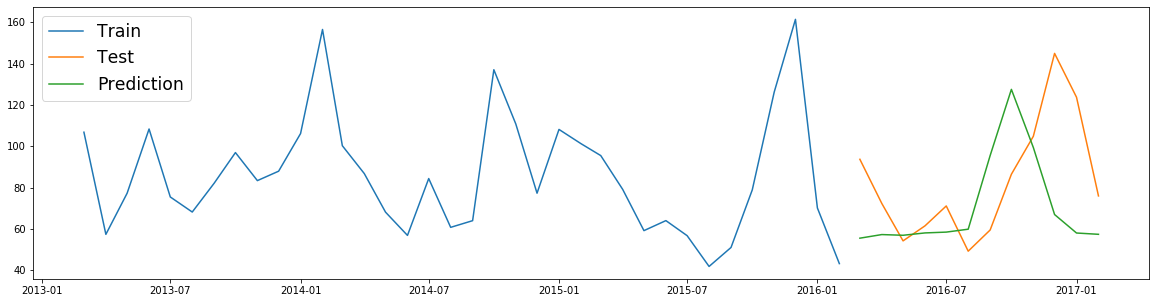


Predictions of  PM10


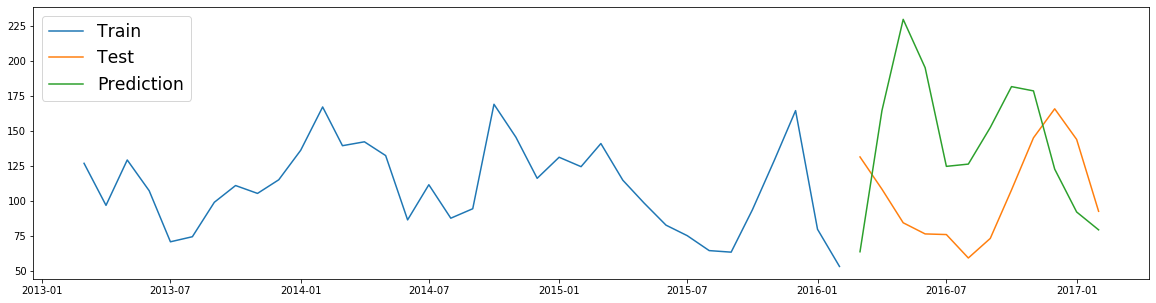


Predictions of  SO2


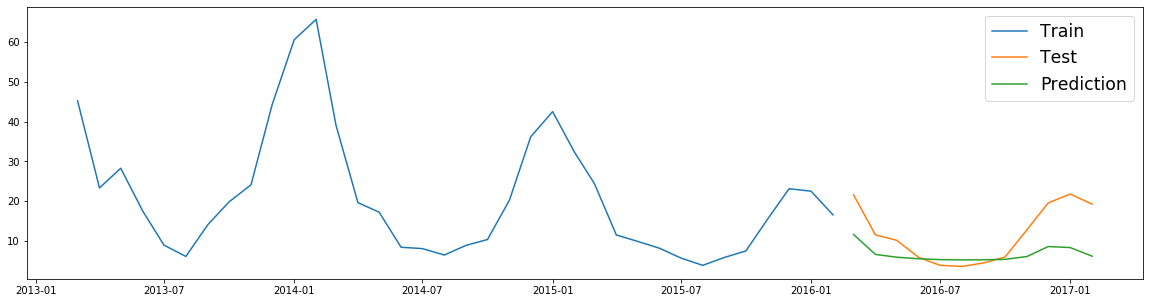


Predictions of  NO2


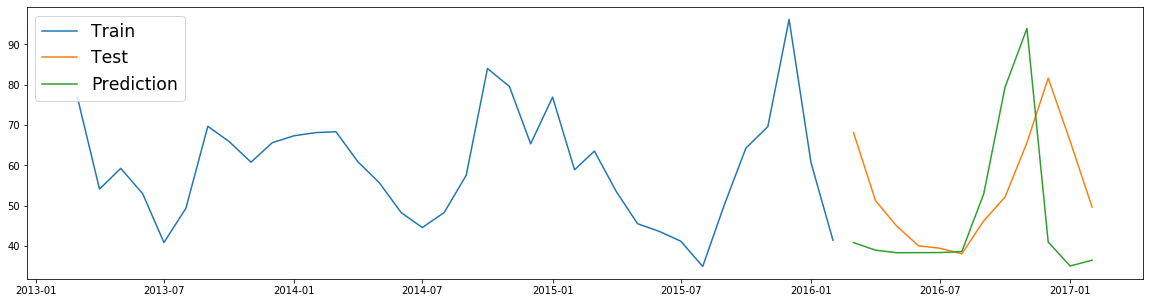


Predictions of  CO


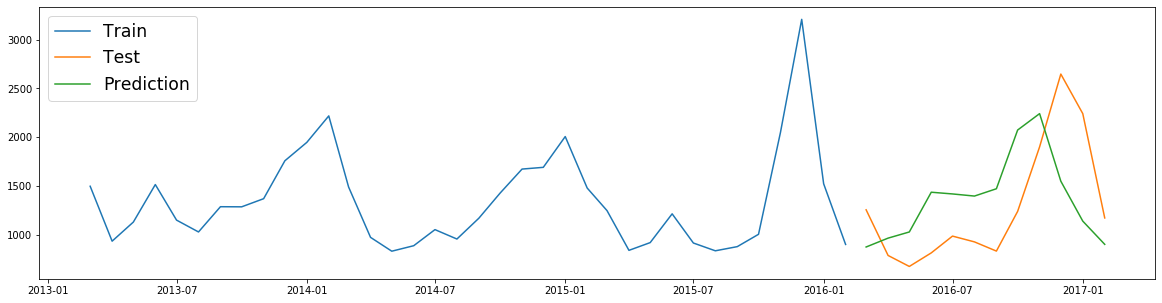


Predictions of  O3


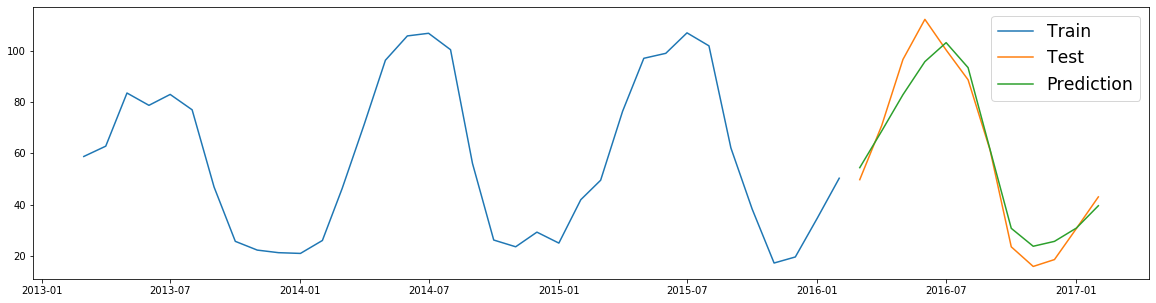

In [14]:
# Predict all the pollutants
list_predictions = [predict_LSTM(list_scaled_train[i], list_scaler[i],\
                                list_train[i], list_test[i],time_steps,\
                                n_feature, list_models[i]) \
                   for i in range(len(list_scaled_train))]


In [59]:
# Evaluate all the models
for i in range(len(list_predictions)):
    # Evaluate each model
    evaluate_LSTM(list_test[i], list_predictions[i])


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 1310.3257
The Mean Absolute Error of the forecasts is 27.2785
The Root Mean Squared Error of the forecasts is 36.1984

Results for PM2.5 successfully saved to result/lstm.csv

Evaluation of  PM10
The Mean Squared Error of the forecasts is 5603.6942
The Mean Absolute Error of the forecasts is 66.4645
The Root Mean Squared Error of the forecasts is 74.8578

Results for PM10 successfully saved to result/lstm.csv

Evaluation of  SO2
The Mean Squared Error of the forecasts is 55.5452
The Mean Absolute Error of the forecasts is 5.6853
The Root Mean Squared Error of the forecasts is 7.4529

Results for SO2 successfully saved to result/lstm.csv

Evaluation of  NO2
The Mean Squared Error of the forecasts is 443.2149
The Mean Absolute Error of the forecasts is 16.3812
The Root Mean Squared Error of the forecasts is 21.0527

Results for NO2 successfully saved to result/lstm.csv

Evaluation of  CO
The Mean Squared Error of the foreca

As we can see from the results, our model fit well only for O3 and SO2.<br>
***Note: We can still improver the model performance by Hyperparameter Tuning. But due to Time contraints we will skip Hyperparameter Tuning and proceed to the final part. Part 6: Final Model Evaluation and Prediction.***